# Исследование объявлений о продаже квартир


<b>Цели исследования</b>:
 - Понять, какие параметры больше всего влияют на скорость продажи недвижимости
 - Какие факторы больше всего влияют на стоимость квартиры
 - Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра
 - Опишем, как расстояние до центра влияет на стоимость квартиры в Санкт-Петербурге


**План работы**:
<ol>
 <li>Открыть файл с данными и изучить общую информацию, построить общую гистограмму для всех числовых данных</li>
 <li>Найти и изучить пропущенные данных, при возможности их заполнить</li>
 <li>Проверить корректность типов данных в каждом столбце</li>
 <li>Изучить уникальные значения в столбце с адресами, убрать неявные дубликаты</li>
 <li>Убрать выбросы данных, при возможности восстановить корректное значение</li>
 <li>Добавить в таблицу дополнительные необходимые для анализа параметры</li>
 <li>Изучить все параметры недвижимости и построить гистограммы для каждого из них</li>
 <li>Изучить как быстро продавались квартиры в зависимости от параметров</li>
 <li>Изучить какие факторы больше всего влияют на общую стоимость объектов</li>
 <li>Посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделить населённые пункты с самой высокой и низкой стоимостью квадратного метра</li>
 <li>Выделить квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислить среднюю цену каждого километра</li>
 <li>Описать, как стоимость объектов зависит от расстояния до центра города</li>
 </ol>

### Откроем файл с данными и изучим общую информацию.

In [ ]:
#Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, date
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [ ]:
#Читаем данные
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [ ]:
#Смотрим на структуру данных на примере первых 5 строк
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
#Переводим данные в нужный формат и смотрим какие столбцы у нас есть, столбец с датой переводим в формат,
#который поймёт машина
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

У нас есть 23699 строк и 22 столбца, есть данные булева типа (принимают значения 1 или 0), категориального и численного. Есть ошибки в типах данных: где должен быть bool стоит object, мы это исправим. Есть много пропущенных значений в колонке ceiling_height, is_apartment, balcony, parks_nearest. В причинах и что с этим можно сделать разберёмся позже. Для того, чтобы посмотреть как данные распределены, построим для каждого столбца гистограмму.

In [ ]:
#Меняем тип данных где это необходимо
data['is_apartment'] = data['is_apartment'].astype('bool')
data['is_apartment']

0        True
1        True
2        True
3        True
4        True
         ... 
23694    True
23695    True
23696    True
23697    True
23698    True
Name: is_apartment, Length: 23699, dtype: bool

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>],
       [<AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'

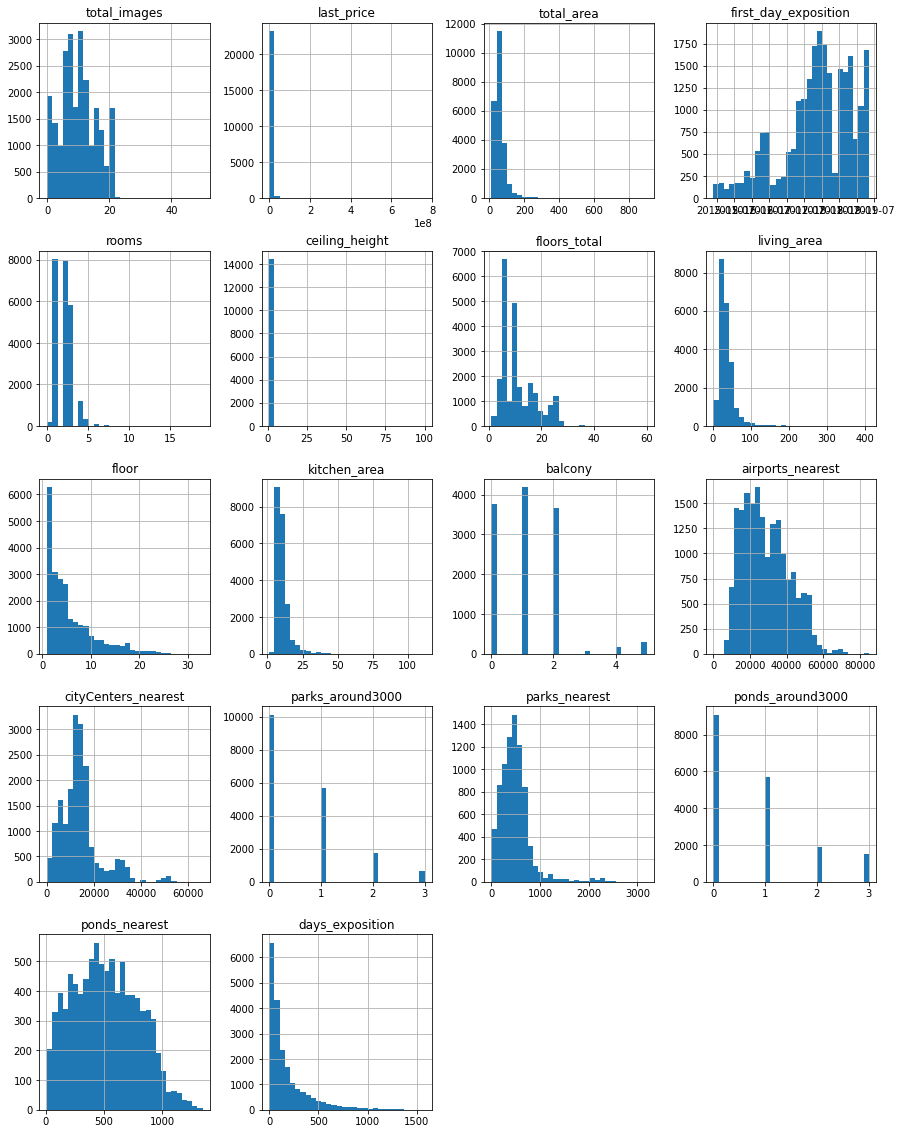

In [ ]:
#Строим гистограмму для каждого столбца
data.hist(figsize=(15,20), bins=30)

Можно сразу заметить странности в колонках last_price (все цены равны нулю), total_area(есть много квартир с площадью 0), ceiling_height(потолки с высотой 0), floor(непонятно что означает этаж 0, стоит глянуть на данные поближе) и days_exposition(большинство квартир были якобы проданы меньше чем через день, выглядит очень неправдоподобно). На самые важные для последующего анализа столбцы взглянем поближе и попробуем их исправить.

#### Обработка last_price

In [ ]:
print('Минимальная цена:',
data['last_price'].min(),'--','Максимальная цена:', data['last_price'].max())


Минимальная цена: 12190.0 -- Максимальная цена: 763000000.0


<AxesSubplot:>

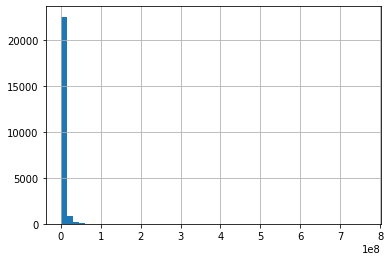

In [ ]:
data['last_price'].hist(bins=50)

У нас в данных есть квартиры, последняя цена которых были 12190 рублей и 763 миллиона рублей. Возможно в случае с минимальной ценой имелось ввиду цена 1 квадратного метра или цена месячного съёма, но не цена всей квартиры: тут точно какая-то ошибка. Квартира с максимальной ценой может быть не ошибкой, теоретически это может быть недвижимость в центре Москвы. Сначала проверим на правдоподобность самые дорогие квартиры.

<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest'>

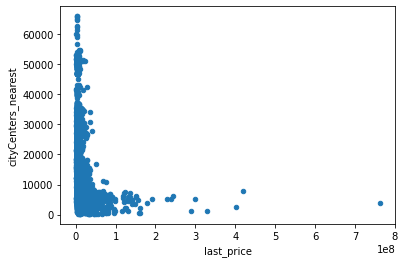

In [ ]:
#Построим диаграмму рассеяния, где с одной стороны будет близость к центру, а с другой последняя цена
data.plot(kind='scatter', x='last_price', y='cityCenters_nearest')

Получается логично, самые дорогие квартиры очень близко в центру

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

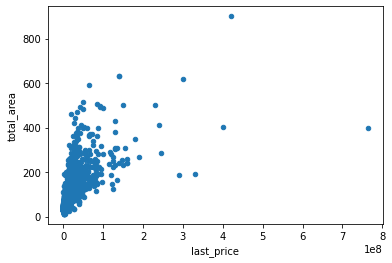

In [ ]:
#Теперь построить диаграмму по общем площади и цене
data.plot(kind='scatter', x='last_price', y='total_area')

Тоже логично, дорогие квартиры очень просторные, от 200 и более квадратных метров. Значит их оставим. Теперь посмотрим на самые маленькие цены.

<AxesSubplot:>

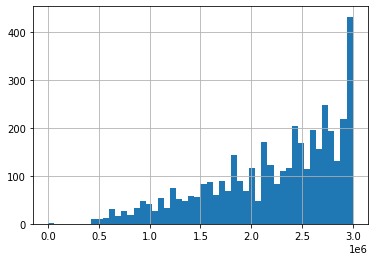

In [ ]:
#Ограничимся 3 миллионами
data['last_price'].hist(bins=50, range=(0, 3000000))


Есть одна квартира за 12 тысяч рублей и разрыв, следующая дешевая квартира стоит 450 000 рублей. Такое может быть, но проверим как цены распределены по городам, ведь в Москве такое невозможно, может тут всё таки ошибка?

In [ ]:
data.pivot_table(index='locality_name', values='last_price').sort_values(by='last_price')

,last_price
locality_name,
деревня Вахнова Кара,4.500000e+05
деревня Старополье,4.600000e+05
деревня Чудской Бор,5.000000e+05
поселок Совхозный,5.175000e+05
посёлок станции Свирь,5.750000e+05
...,...
Санкт-Петербург,8.062507e+06
посёлок Александровская,8.725000e+06
деревня Бор,1.039760e+07


Самые дешевые квартиры в деревнях и посёлках, логично. Но самые высокие цены в деревнях --  это странно, надо проверить на аномалии. Однако уже можно сказать, что нижняя граница данных будет на 450 000 рублей,от этой цены идёт плавный подъём.

In [ ]:
#Оставляем только данные где цена более 450 000 рублей
data = data[(data['last_price'] >= 450000) |  (data['last_price'].isna())]

<AxesSubplot:>

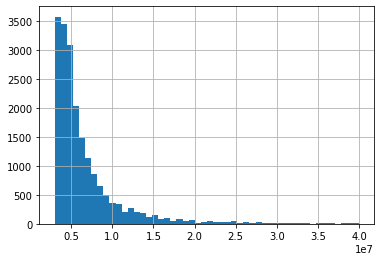

In [ ]:
data['last_price'].hist(bins=50, range=(3000000, 40000000))

In [ ]:
#Количество недвижимости с очень высокой ценой
len(data[data['last_price']>=20000000])

723

In [ ]:
#Сделаем список городов с самыми дорогими квартирами
too_expensive = data[data['last_price']>=20000000]
too_expensive = too_expensive.pivot_table(index='locality_name',
                                          values='last_price',
                                          aggfunc={'last_price':['count', 'mean', 'median']}).reset_index()
too_expensive

,locality_name,count,mean,median
0,Всеволожск,1,2.441290e+07,24412900.0
1,Зеленогорск,1,2.300000e+07,23000000.0
2,Колпино,1,3.690000e+07,36900000.0
3,Красное Село,1,2.100000e+07,21000000.0
4,Петергоф,2,2.200000e+07,22000000.0
5,Пушкин,9,2.924637e+07,26500000.0
6,Санкт-Петербург,704,4.281544e+07,28849500.0
7,Сестрорецк,1,2.170000e+07,21700000.0
8,деревня Бор,1,2.029520e+07,20295200.0
9,посёлок Репино,1,2.800000e+07,28000000.0


In [ ]:
#Сколько всего объявлений о продаже квартир из городов с аномально высокой ценой
for i in too_expensive['locality_name']:
    print(i, (data['locality_name']==i).sum())

Всеволожск 398
Зеленогорск 24
Колпино 338
Красное Село 178
Петергоф 201
Пушкин 369
Санкт-Петербург 15720
Сестрорецк 183
деревня Бор 2
посёлок Репино 4


Такие высокие цены это единичные случаи для городов кроме Пушкина и Санкт-Петербурга. Тем не менее, это может быть реальное элитное жилье,  поэтому оставим их как было

Нам удалось удалить ошибочные строчки, ограничив диапозон значений снизу (450 тыс. рублей)

#### обработка ceiling_height

In [ ]:
print('Минимальные потолки:',
data['ceiling_height'].min(),'--','Максимальные потолки:', data['ceiling_height'].max())

Минимальные потолки: 1.0 -- Максимальные потолки: 100.0


Потолки в 100 метров высотой сложно представить, как и потолки в 1 метр, тут может быть что-то не так, стоит посмотреть на их распределение


<AxesSubplot:>

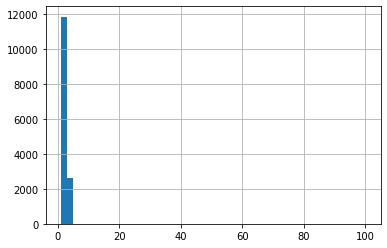

In [ ]:
data['ceiling_height'].hist(bins=50)

Видимо есть только одно значение потолка 100, нужно посмотреть на общую массу потолком, ограничим область


<AxesSubplot:>

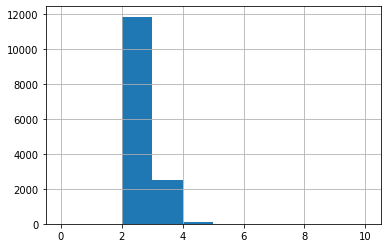

In [ ]:
data['ceiling_height'].hist(bins=10, range=(0, 10))

Основная масса данных нормальная, однако можно увидеть странности: потолки больше 4 метров


In [ ]:
data['ceiling_height'].sort_values(ascending=False)

22869    100.0
22336     32.0
3148      32.0
21377     27.5
22938     27.0
         ...  
23687      NaN
23690      NaN
23692      NaN
23695      NaN
23696      NaN
Name: ceiling_height, Length: 23695, dtype: float64

Мы встретились с аномалиями, сложно представить себе потолок высотой 32 метра, вероятнее всего тут ошибка, вместо 3.2 люди написали 32, мы это исправим.


In [ ]:
data.loc[data['ceiling_height'] >=20, 'ceiling_height']  = data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] * 0.1
data['ceiling_height'].sort_values(ascending=False)

15061    14.0
22309    10.3
22869    10.0
5863      8.3
15743     8.0
         ... 
23687     NaN
23690     NaN
23692     NaN
23695     NaN
23696     NaN
Name: ceiling_height, Length: 23695, dtype: float64

<AxesSubplot:>

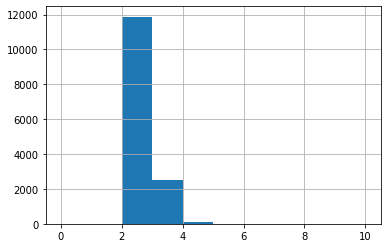

In [ ]:
data['ceiling_height'].hist(range=(0, 10))

Всё равно остались данные которые не похожи на правду, чтобы эти аномалные значения не портили наше исследование мы ограничим 6 метрами, после 6 метров аномальные значения потолкой были отмеченемы минимальным количеством людей, скорее всего это просто опечатка.

<AxesSubplot:>

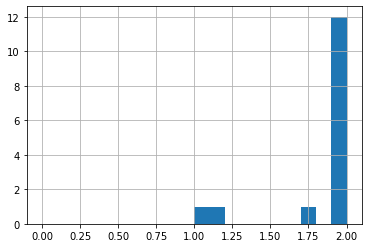

In [ ]:
data['ceiling_height'].hist(range=(0, 2), bins=20)

In [ ]:
data.query('ceiling_height == 1.75')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37.0,17.4,5,True,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0


Есть значения потолка 1 метр, это точно ошибка, значение 1.75, принадлежит квартире 5 этажа в 37 этажном доме в Питере, значит это тоже ошибка. В поддержку этой теории говорит также и то, что эти значения единичные.

9192

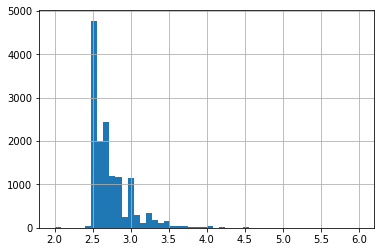

In [ ]:
data = data[(data['ceiling_height'] <= 6) & (data['ceiling_height'] >=2) | (data['ceiling_height'].isna())]
data['ceiling_height'].hist(bins=50)
data['ceiling_height'].isna().sum()

Итак, сначала бы изучили все аномалии и исправили те, которые было возможно исправить, данные которые исправить не удалось мы убрали из данных чтобы они не искажали наши дальнейшие исследования.

#### обработка floor

In [ ]:
print('Минимальный этаж:',
data['floor'].min(),'--','Максимальный этаж:', data['floor'].max())

Минимальный этаж: 1 -- Максимальный этаж: 33


<AxesSubplot:>

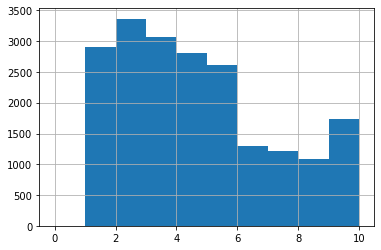

In [ ]:
data['floor'].hist(bins=10, range=(0, 10))

Нулевых этажей нет, можно работать с данными дальше

#### обработка days_exposition

In [ ]:
print('min продали через дней:',
data['days_exposition'].min(),'--','max продали через дней:', data['days_exposition'].max())

min продали через дней: 1.0 -- max продали через дней: 1580.0


Нулей не оказалось, однако посмотрим на всякий случай на распределение данных

<AxesSubplot:>

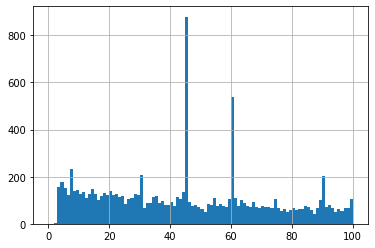

In [ ]:
data['days_exposition'].hist(bins=100, range=(0, 100))

In [ ]:
data[data['days_exposition']>= 4].value_counts('days_exposition').sort_values(ascending=False)

days_exposition
45.0      879
60.0      538
7.0       234
30.0      208
90.0      204
         ... 
1179.0      1
1373.0      1
1368.0      1
1182.0      1
1580.0      1
Length: 1138, dtype: int64

Есть два выброса, 396 квартир было продано в 45 день и 274 на 60 день

In [ ]:
data_dos = data
data_dos['day_of_sell'] = data_dos['first_day_exposition'] + timedelta(days=60)
data_dos.query('days_exposition == 60').value_counts('day_of_sell')

day_of_sell
2018-01-09    12
2018-02-16    11
2018-02-05     6
2018-09-15     6
2018-02-12     6
              ..
2018-01-20     1
2018-02-09     1
2018-02-10     1
2018-02-11     1
2019-04-29     1
Length: 309, dtype: int64

В 2018 году 1 января был введён новый закон о льготных условия ипотеки для семей с 2 и более детьми, этот фактор и был причиной такого резкого возрастания количества покупок после новогодних праздников 2018 года, а 9 февраля ЦБ снизил ключевую ставку, давая возможность банкам снизить требования для ипотек, по всей видимости это повлияло на всплекс покупок квартир 16 февраля, так как банки не могут изменить требования в тот же час, им требовалось некоторое время для принятия решения. Значит с данными всё в порядке, можно с ними работать.

In [ ]:
data_dos = data
data_dos['day_of_sell'] = data_dos['first_day_exposition'] + timedelta(days=45)
#data_dos.query('days_exposition == 45').value_counts('day_of_sell') #почему то так не считает, так и не понял в чём дело
data_dos.query('days_exposition > 44 and days_exposition < 46').value_counts('day_of_sell')


day_of_sell
2018-03-24    17
2018-01-23    13
2018-01-21    12
2018-02-25    12
2018-04-06    11
              ..
2017-11-25     1
2017-12-01     1
2017-12-02     1
2017-12-07     1
2019-05-02     1
Length: 452, dtype: int64

Согласно <a id='https://realty.rbc.ru/news/5b56005d9a7947541d673119'>РБК</a>, за март 2018 года жители России взяли рекордное за год количество ипотек на сумму 249 млрд. рублей. В таком случае наши данные это не ошибка, с ними можно работать.

#### обработка living_area

In [ ]:
print('Минимальная площадь:',
data['living_area'].min(),'--','Максимальная площадь:', data['living_area'].max())

Минимальная площадь: 2.0 -- Максимальная площадь: 409.7


<AxesSubplot:>

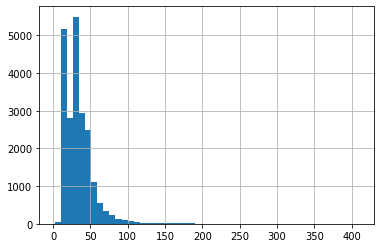

In [ ]:
data['living_area'].hist(bins=50)

In [ ]:
data.query('living_area > 200')['locality_name'].value_counts()

Санкт-Петербург    30
Пушкин              1
Name: locality_name, dtype: int64

Квартиры где жилая площадь больше 200 кв.метров все до одной находятся в Санкт-Петербурге, это не выглядит как ошибка, оставим эти данные

In [ ]:
data.query('living_area <=5').sort_values('living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,day_of_sell
13915,20,6350000.0,52.0,2018-02-06,2,3.0,6.0,2.0,2,True,...,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0,2018-03-23
21758,0,2330000.0,23.0,2018-01-01,0,NaN,24.0,2.0,22,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0,2018-02-15
3242,7,4440000.0,41.0,2017-07-02,1,NaN,17.0,3.0,17,True,...,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0,2017-08-16
23574,14,64990000.0,139.0,2015-11-24,3,3.0,8.0,3.0,8,True,...,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0,2016-01-08
17582,11,2680000.0,22.0,2018-08-11,0,NaN,25.0,5.0,8,True,...,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0,2018-09-25


Нелогичными выглядят только данные о жилой площади 3-х и 2-х квадратных метров, остальное выглядит реалистичным. При возможности нужно сохранять как можно больше данных, поэтому заменим жилую площадь найденной квартиры медианным значением по городу.

In [ ]:
#Заменяем жилую площадь 3 на медиану по городу
data['living_area'] = (
data['living_area'].where(data['living_area'] > 3,
                          data[data['living_area']=='Санкт-Петербург']['living_area'].median())
)

In [ ]:
#Проверяем, что код сработал и значение заменилось
data['living_area'].min()

5.0

Проверим, нет ли такого, что жилая площадь больше общей площади

In [ ]:
#Считаем, сколько у нас строк, где жилая площадь больше общей
((data['total_area'] - data['living_area'])<0).sum()

0

Данные в порядке, чтобы с ними работать дальше

#### обработка total_area

In [ ]:
print('Минимальная площадь:',
data['total_area'].min(),'--','Максимальная площадь:', data['total_area'].max())

Минимальная площадь: 12.0 -- Максимальная площадь: 900.0


<AxesSubplot:>

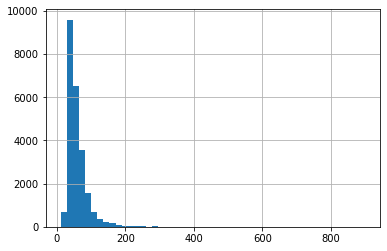

In [ ]:
data['total_area'].hist(bins=50)

Низкие значения в порядке, но высокие настораживают, стоит их проверить

In [ ]:
data.query('total_area > 300')['locality_name'].value_counts()

Санкт-Петербург    57
Пушкин              2
Колпино             1
Красное Село        1
Name: locality_name, dtype: int64

In [ ]:
data.query('total_area > 300')[['rooms', 'locality_name']].value_counts()

rooms  locality_name  
5      Санкт-Петербург    16
7      Санкт-Петербург    15
6      Санкт-Петербург     7
4      Санкт-Петербург     5
9      Санкт-Петербург     4
8      Санкт-Петербург     3
0      Санкт-Петербург     1
15     Санкт-Петербург     1
14     Санкт-Петербург     1
12     Санкт-Петербург     1
7      Пушкин              1
8      Колпино             1
1      Санкт-Петербург     1
6      Пушкин              1
       Красное Село        1
3      Санкт-Петербург     1
19     Санкт-Петербург     1
dtype: int64

Квартиры с большой общей площадью имеют много комнат и все находятся в Санкт-Петербурге, значит это скорее всего не ошибка, оставим данные этой колонки как были.

#### Обработка floors_total

In [ ]:
print("Минимальное количество общего числа этажей",data['floors_total'].min(), "Максимальное количество общего числа этажей", data['floors_total'].max())

Минимальное количество общего числа этажей 1.0 Максимальное количество общего числа этажей 60.0


In [ ]:
data['floors_total'].value_counts().sort_values()

33.0       1
29.0       1
34.0       1
52.0       1
60.0       1
36.0       3
28.0      21
35.0      24
1.0       25
26.0     124
21.0     158
27.0     164
11.0     203
13.0     229
20.0     271
22.0     286
19.0     339
23.0     352
15.0     365
2.0      381
8.0      390
24.0     469
18.0     505
14.0     552
7.0      592
3.0      667
17.0     833
6.0      914
25.0    1074
10.0    1174
4.0     1200
12.0    1361
16.0    1373
9.0     3761
5.0     5784
Name: floors_total, dtype: int64

60-29 этажей это подозрительно, в каком это городе?

In [ ]:
data[data['floors_total']>=29][['locality_name', 'last_price', 'floors_total']].sort_values('last_price')

,locality_name,last_price,floors_total
9579,Санкт-Петербург,3450000.0,35.0
1697,Санкт-Петербург,3550000.0,34.0
5749,Санкт-Петербург,3590000.0,35.0
2253,Кронштадт,3800000.0,60.0
16731,Санкт-Петербург,3978000.0,52.0
3797,посёлок Парголово,4100000.0,29.0
2966,Санкт-Петербург,4300000.0,35.0
5808,Санкт-Петербург,4590000.0,35.0
7236,Санкт-Петербург,4599000.0,35.0
1060,Санкт-Петербург,5200000.0,35.0


Дом в Спб с 35 этажами это не ошибка, это ЖК "Князь Александр Невский", а данные указывающие 36 и 34 скорее всего имели ввиду 35, всё таки когда так много этажей легко ошибиться. Жилых домов выше упомянутого в Спб нет, тем паче их нет в Кронштадте. Посёлок Парголово это аналог Мурино, дом с 29 этажами это не ошибка. В соответствии со всем этим исправим указанные данные и удалим ошибочные.

In [ ]:
#Заменяем значения
data.loc[(data['floors_total'] == 36) & (data['locality_name']=='Санкт-Петербург'), 'floors_total'] = (35)
data.loc[(data['floors_total'] == 34) & (data['locality_name']=='Санкт-Петербург'), 'floors_total'] = (35)

In [ ]:
#Отрезаем данные где общаяя этажность больше 36 метров
data = data.query('floors_total < 36')

In [ ]:
#Смотрим как получилось
data[data['floors_total']>=29][['locality_name', 'last_price', 'floors_total']].sort_values('last_price')

,locality_name,last_price,floors_total
9579,Санкт-Петербург,3450000.0,35.0
1697,Санкт-Петербург,3550000.0,35.0
5749,Санкт-Петербург,3590000.0,35.0
3797,посёлок Парголово,4100000.0,29.0
2966,Санкт-Петербург,4300000.0,35.0
5808,Санкт-Петербург,4590000.0,35.0
7236,Санкт-Петербург,4599000.0,35.0
1060,Санкт-Петербург,5200000.0,35.0
4855,Санкт-Петербург,5500000.0,35.0
18629,Санкт-Петербург,5700000.0,35.0


#### Подвывод общей информации данных:
у нас есть 22 столбца и около 30 тысяч строк данных, в некоторых есть много пропусков, в причине возникновения которых придётся разобраться и при возможности заполнить. Мы заменили типы данных там, где это было необходимо, посмотрели на распределение всех количественных данных. Все данные с подозрительными выбросами мы проверили, которые было возможно исправить -- исправили, а некоторые пришлось совсем убрать из данных, чтобы они не искажали наше будущее исследование.

### Предобработка данных

У нас есть колонка с наименованиями населённых пунктов, каждый может записываться несколькими способами и перед тем как работать со столбцом дальше, нам нужно избавиться от неявных дубликатов

#### Унификация названия населённых пунктов

##### преобработка locality_name

Так выглядит наш список городов. Сразу можно заметить что дублируется Мурино: его записывали и как Мурино, и как посёлок Мурино и тд. Нужно привести все названия городов к одному типу.

In [ ]:
#Заменим пропуски чтобы не выдавало ошибок
data['locality_name'].isna().sum()
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

In [ ]:
#Проверяем точно ли всё заменили
data['locality_name'].isna().sum()

0

In [ ]:
#Все названия городов которые есть в столбце
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [ ]:
#Делаем словарь для будущей унификации
replace_dict = {
    'посёлок': 'поселок',
    'мурино': 'поселок Мурино',
    'посёлок Мурино': 'поселок Мурино',
    'городской посёлок': 'поселок городского типа',
    'городской поселок': 'поселок городского типа',
    'посёлок городского типа': 'поселок городского типа',
    'поселок городского типа': 'поселок городского типа',
    'садовое некоммерческое товарищество': 'садовое товарищество',
    'посёлок при железнодорожной станции': 'поселок',
    'поселок при железнодорожной станции': 'поселок',
    'коттеджный поселок': 'поселок',
    'коттеджный посёлок': 'поселок',
    'поселок станции': 'поселок',

}

In [ ]:
#Соединяем эти две функции в одну
def locality_name_processing(text):
    #заменяем ключи на значения
    for key, value in replace_dict.items():
        text = text.replace(key, value)
    return text
#Создаём новый столбец с унифицированными значениями
data['locality_name_processed'] = data['locality_name'].apply(locality_name_processing)


In [ ]:
#Проверяем как работает: всё ок
data['locality_name_processed'].unique()

array(['Санкт-Петербург', 'поселок Шушары',
       'поселок городского типа Янино-1', 'поселок Парголово',
       'поселок Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посел

Теперь у нас универсилизированные названия населённых пунктов

#### Работа с пропусками

In [ ]:
#Для начала определим, какая доля пропусков в каждом столбце
data.isna().mean().sort_values(ascending=False)

parks_nearest              0.659363
ponds_nearest              0.616265
balcony                    0.485994
ceiling_height             0.386278
airports_nearest           0.234225
cityCenters_nearest        0.233250
ponds_around3000           0.233208
parks_around3000           0.233208
days_exposition            0.134381
kitchen_area               0.094376
living_area                0.079332
day_of_sell                0.000000
locality_name              0.000000
total_images               0.000000
last_price                 0.000000
open_plan                  0.000000
studio                     0.000000
is_apartment               0.000000
floor                      0.000000
floors_total               0.000000
rooms                      0.000000
first_day_exposition       0.000000
total_area                 0.000000
locality_name_processed    0.000000
dtype: float64

Много колонок с пропусками, в некоторых доля пропусков достигает 90%! Попробуем с этим что-то сделать, обработаем колонки с процентов пропусков более 10%, такое количество пропусков может быть критичным.

##### пропуски в is_apartment

In [ ]:

print(data.query('is_apartment == 1').value_counts(subset='locality_name').head(5))
print(data.query('is_apartment == 0').value_counts(subset='locality_name').head(5))
print(data.query('is_apartment.isna()').value_counts(subset='locality_name').head(5))

locality_name
Санкт-Петербург    13848
посёлок Мурино       466
посёлок Шушары       381
Всеволожск           355
Пушкин               321
dtype: int64
locality_name
Санкт-Петербург    1794
посёлок Шушары       58
посёлок Мурино       54
Пушкин               48
деревня Кудрово      48
dtype: int64
Series([], dtype: int64)


Пропуски не случайны, так как зависят от характера вопроса. Самые частовстречаемые населенные пункты с НЕапартаментами это Спб множество посёлков и деревень, так апартаментам неоткуда появиться. Помимо этого, владельцы НЕапартаментов просто не отмечают этот пункт, полагая что система по умолчанию отметит их квартиру как НЕапартаменты. Информцию о данной особенности системы стоит подсветить инженерам для оптимизации дальнейших выгрузок данных. Пропуски можно заполнить нулями.


In [ ]:
#Меняем пустые места на нули и снова считаем количество пропусков в этой колонке
data['is_apartment'] = data['is_apartment'].fillna(0)
data['is_apartment'].isna().sum()

0

##### пропуски в parks_nearest

In [ ]:
#Количество пропусков
print((data['parks_nearest'] > 0).sum())
print((data['parks_nearest'] == 0).sum())
data['parks_nearest'].isna().sum()

8038
0


15559

Картографические данные такого рода сложно заполнить, поэтому пропуски так и оставим. Причиной пропусков могут быть:
 - люди не отмечали парки в том случае, когда парков по близости нет
 - люди не знали точного расстояния до парка и решили вообще не заполнять
 - люди не хотели тратить слишком много времнени на создание объявления и решили не заполнять информацию, которая кажется им не критичной

##### пропуски в ponds_nearest

In [ ]:
print((data['ponds_nearest'] >= 1).sum())
print((data['ponds_nearest'] == 0).sum())
data['ponds_nearest'].isna().sum()

9055
0


14542

Как и в предыдущем пункте, оставляем пропуски как есть

##### пропуски в balcony

Логично предположить, что если владелец квартиры не указал количество балконов, значит их просто нет.

In [ ]:
print(data['balcony'].value_counts())
data['balcony'].isna().sum()

1.0    4193
0.0    3713
2.0    3656
5.0     303
4.0     183
3.0      81
Name: balcony, dtype: int64


11468

In [ ]:
#Заполняем и проверям
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

#####  пропуски в ceiling_height

In [ ]:
data['ceiling_height'].isna().sum()

9115

In [ ]:
data.pivot_table(index='locality_name_processed',
                 values='ceiling_height',
                 aggfunc='median')

,ceiling_height
locality_name_processed,
Бокситогорск,3.90
Волосово,2.50
Волхов,2.58
Всеволожск,2.70
Выборг,2.55
...,...
садовое товарищество Рахья,2.60
село Копорье,2.50
село Павлово,2.75


In [ ]:
#Меняем пустые на медианы по городу
for city in data['locality_name_processed'].unique():
        data.loc[(data['locality_name_processed'] == city) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
        data.loc[(data['locality_name_processed'] == city), 'ceiling_height'].median()

In [ ]:
data[data['ceiling_height'].isna()]['locality_name_processed'].value_counts()

поселок Кобринское                                         6
поселок Усть-Луга                                          5
поселок Селезнёво                                          5
деревня Заклинье                                           3
деревня Торошковичи                                        3
                                                          ..
садоводческое некоммерческое товарищество Лесная Поляна    1
поселок Тёсово-4                                           1
поселок Каложицы                                           1
поселок Алексеевка                                         1
деревня Трубников Бор                                      1
Name: locality_name_processed, Length: 68, dtype: int64

Высоту потолков по этим городам мы заполнили медианой по городу. Причиной пропусков может быть, что владельцы не уверены какой высоты у них потолки (поэтому ничего не пишут, чтобы не обмануть), люди могли не заметить этот пункт на сайте или могли просто полениться заполнить данные.

##### пропуски в airports_nearest

In [ ]:
data['airports_nearest'].isna().sum()

5527

In [ ]:
data.pivot_table(index='locality_name_processed',
                 values='airports_nearest',
                 aggfunc='median')

,airports_nearest
locality_name_processed,
Зеленогорск,72282.0
Колпино,26232.0
Красное Село,25730.0
Кронштадт,67872.5
Ломоносов,48415.5
Неизвестно,22669.0
Павловск,20529.5
Петергоф,39231.0
Пушкин,15766.0


In [ ]:
#Меняем пустые на медианы по городу
for city in data['locality_name_processed'].unique():
        data.loc[(data['locality_name_processed'] == city) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
        data.loc[(data['locality_name_processed'] == city), 'airports_nearest'].median()

In [ ]:
data['airports_nearest'].isna().sum()

5427

Причина: люди оставляют пустым там, где аэропорта поблизости нет, так и оставим

##### пропуски в cityCenters_nearest

In [ ]:
data['cityCenters_nearest'].isna().sum()

5504

Картографические данные об удалённости от центра города сложно с достаточной достоверностью заполнить, придётся оставить их пустыми

##### пропуски в ponds_around3000  

In [ ]:
data['ponds_around3000'].isna().sum()

5503

In [ ]:
data.pivot_table(index='locality_name_processed',
                 values='ponds_around3000',
                 aggfunc='median')

,ponds_around3000
locality_name_processed,
Зеленогорск,1.0
Колпино,1.0
Красное Село,0.0
Кронштадт,2.0
Ломоносов,1.0
Неизвестно,1.0
Павловск,2.0
Петергоф,1.0
Пушкин,0.0


In [ ]:
#Меняем пустые на медианы по городу
for city in data['locality_name_processed'].unique():
        data.loc[(data['locality_name_processed'] == city) & (data['ponds_around3000'].isna()), 'ponds_around3000'] = \
        data.loc[(data['locality_name_processed'] == city), 'ponds_around3000'].median()

In [ ]:
data['ponds_around3000'].isna().sum()

5427

In [ ]:
(data['ponds_around3000']==0).sum()

9044

In [ ]:
#0 означает поблизости такого нет
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

Оставляют пустым в основном по причине того, что прудов рядом нет, пропуки которые владельцы квартир поленились заполнить (или забыли) мы заполнили медианой по этому городу.

##### пропуски в parks_around3000

In [ ]:
data['parks_around3000'].isna().sum()

5503

In [ ]:
data.pivot_table(index='locality_name_processed', values='parks_around3000', aggfunc='median')

,parks_around3000
locality_name_processed,
Зеленогорск,3.0
Колпино,0.0
Красное Село,0.0
Кронштадт,2.0
Ломоносов,0.0
Неизвестно,0.0
Павловск,2.0
Петергоф,1.0
Пушкин,1.0


In [ ]:
#Меняем пустые на медианы по городу
for city in data['locality_name_processed'].unique():
        data.loc[(data['locality_name_processed'] == city) & (data['parks_around3000'].isna()), 'parks_around3000'] = \
        data.loc[(data['locality_name_processed'] == city), 'parks_around3000'].median()

In [ ]:
data['parks_around3000'].isna().sum()

5427

In [ ]:
(data['parks_around3000']==0).sum()

10135

In [ ]:
#0 означает поблизости такого нет
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

Причины и логика та же, что и с прудами.

##### пропуски в days_exposition

In [ ]:
#Сколько пропущенных значений в колонке
data['days_exposition'].isna().sum()

3171

In [ ]:
#Сводная таблица по городу и медианой дней продажи кваритиры в нём
data.pivot_table(index='locality_name_processed',
                 values='days_exposition',
                 aggfunc='median').reset_index().sort_values(by='days_exposition')

,locality_name_processed,days_exposition
158,поселок Заводской,5.0
144,поселок Володарское,5.0
284,садовое товарищество Садко,7.0
232,поселок Счастье,7.0
132,деревня Яльгелево,7.0
...,...,...
180,поселок Любань,654.0
171,поселок Коробицыно,750.0
105,деревня Рабитицы,1007.0
185,поселок Молодёжное,1043.0


In [ ]:
#Посмотрим на данные квартир с пропусками в колонке days_exposition
cities_missing = data[data['days_exposition'].isna()]
cities_missing

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,day_of_sell,locality_name_processed
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,True,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-04-21,Санкт-Петербург
7,5,7915000.0,71.60,2019-04-18,2,2.70,24.0,NaN,22,True,...,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,2019-06-02,Санкт-Петербург
44,13,5350000.0,40.00,2018-11-18,1,2.70,22.0,NaN,3,True,...,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN,2019-01-02,Санкт-Петербург
45,17,5200000.0,50.60,2018-12-02,2,2.65,9.0,30.3,7,True,...,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN,2019-01-16,Санкт-Петербург
46,17,6600000.0,52.10,2019-01-31,2,2.60,24.0,29.7,9,True,...,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN,2019-03-17,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02,4,3.00,26.0,71.4,17,True,...,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN,2018-12-17,Санкт-Петербург
23685,15,2490000.0,31.00,2019-01-24,1,2.50,5.0,17.3,5,True,...,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN,2019-03-10,Ломоносов
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,True,...,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,2017-05-05,Санкт-Петербург
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,True,...,село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2018-03-28,село Рождествено


 - days_exposition — сколько дней было размещено объявление (от публикации до снятия)

Самая вероятная и причина пропусков это факт что квартира до сих не снята с продажи, поэтому такие пропуски нет смысла заполнять, оставим пропуски как есть

##### Подвывод
Мы унифицировали названия населённых пунктов для корректного заполнения пропусков, выявили природу пропусков, и в зависимости от причины пропусков либо заполнили их медианой или оставили пустыми

### Посчитаем и добавим в таблицу новые столбцы

#### Добавляем столбцы

##### Добавляем столбец цены одного кв. метра

In [ ]:
#Вспоминаем как выглядят наши данные
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,day_of_sell,locality_name_processed
0,20,13000000.0,108.0,2019-03-07,3,2.700,16.0,51.0,8,True,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-04-21,Санкт-Петербург
1,7,3350000.0,40.4,2018-12-04,1,2.615,11.0,18.6,1,True,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2019-01-18,поселок Шушары
2,10,5196000.0,56.0,2015-08-20,2,2.700,5.0,34.3,4,True,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-10-04,Санкт-Петербург
3,0,64900000.0,159.0,2015-07-24,3,2.700,14.0,NaN,9,True,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-09-07,Санкт-Петербург
4,2,10000000.0,100.0,2018-06-19,2,3.030,14.0,32.0,13,True,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-08-03,Санкт-Петербург


In [ ]:
#Добавляем столбец и смотрим каким он получился
data['sq_m_price'] = data['last_price'] / data['total_area']
data['sq_m_price']

0        120370.370370
1         82920.792079
2         92785.714286
3        408176.100629
4        100000.000000
             ...      
23694     72490.845228
23695     52542.372881
23696     44091.710758
23697    149511.400651
23698     41795.665635
Name: sq_m_price, Length: 23597, dtype: float64

##### Добавляем столбец дня недели публикации объявления

In [ ]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['weekday']

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: weekday, Length: 23597, dtype: int64

#####  Добавляем столбец месяца публикации объявления

In [ ]:
data['month'] = data['first_day_exposition'].dt.month
data['month']

0         3
1        12
2         8
3         7
4         6
         ..
23694     3
23695     1
23696     2
23697     3
23698     7
Name: month, Length: 23597, dtype: int64

#####  Добавляем столбец года недели публикации объявления

In [ ]:
data['year'] = data['first_day_exposition'].dt.year
data['year']

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: year, Length: 23597, dtype: int64

#####  Добавляем столбец типа этажа квартиры

In [ ]:
#Создаём функцию для типизации этажей
def floor_type(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floors_total'] - row['floor'] == 0:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

In [ ]:
#Применяем функцию к строчкам и проверяем как она сработала
data['floor_type'] = data.apply(floor_type, axis=1)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,day_of_sell,locality_name_processed,sq_m_price,weekday,month,year,floor_type
0,20,13000000.0,108.00,2019-03-07,3,2.700,16.0,51.0,8,True,...,2.0,755.0,NaN,2019-04-21,Санкт-Петербург,120370.370370,3,3,2019,другой
1,7,3350000.0,40.40,2018-12-04,1,2.615,11.0,18.6,1,True,...,0.0,NaN,81.0,2019-01-18,поселок Шушары,82920.792079,1,12,2018,первый
2,10,5196000.0,56.00,2015-08-20,2,2.700,5.0,34.3,4,True,...,2.0,574.0,558.0,2015-10-04,Санкт-Петербург,92785.714286,3,8,2015,другой
3,0,64900000.0,159.00,2015-07-24,3,2.700,14.0,NaN,9,True,...,3.0,234.0,424.0,2015-09-07,Санкт-Петербург,408176.100629,4,7,2015,другой
4,2,10000000.0,100.00,2018-06-19,2,3.030,14.0,32.0,13,True,...,1.0,48.0,121.0,2018-08-03,Санкт-Петербург,100000.000000,1,6,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.700,5.0,73.3,3,True,...,3.0,381.0,NaN,2017-05-05,Санкт-Петербург,72490.845228,1,3,2017,другой
23695,14,3100000.0,59.00,2018-01-15,3,2.500,5.0,38.0,4,True,...,0.0,NaN,45.0,2018-03-01,Тосно,52542.372881,0,1,2018,другой
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,True,...,0.0,NaN,NaN,2018-03-28,село Рождествено,44091.710758,6,2,2018,первый
23697,13,11475000.0,76.75,2017-03-28,2,3.000,17.0,NaN,12,True,...,3.0,196.0,602.0,2017-05-12,Санкт-Петербург,149511.400651,1,3,2017,другой


#####  Добавляем столбец расстояние до центра города в километрах

In [ ]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,day_of_sell,locality_name_processed,sq_m_price,weekday,month,year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.700,16.0,51.0,8,True,...,755.0,NaN,2019-04-21,Санкт-Петербург,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.615,11.0,18.6,1,True,...,NaN,81.0,2019-01-18,поселок Шушары,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.700,5.0,34.3,4,True,...,574.0,558.0,2015-10-04,Санкт-Петербург,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.700,14.0,NaN,9,True,...,234.0,424.0,2015-09-07,Санкт-Петербург,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.030,14.0,32.0,13,True,...,48.0,121.0,2018-08-03,Санкт-Петербург,100000.000000,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.700,5.0,73.3,3,True,...,381.0,NaN,2017-05-05,Санкт-Петербург,72490.845228,1,3,2017,другой,4.0
23695,14,3100000.0,59.00,2018-01-15,3,2.500,5.0,38.0,4,True,...,NaN,45.0,2018-03-01,Тосно,52542.372881,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,True,...,NaN,NaN,2018-03-28,село Рождествено,44091.710758,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.000,17.0,NaN,12,True,...,196.0,602.0,2017-05-12,Санкт-Петербург,149511.400651,1,3,2017,другой,10.0


##### Подвывод
Мы добавили столбцы, которые понадобятся нам в дальнейшем исследовании

### Проведём исследовательский анализ данных

#### Постройка гистограм для каждого параметра объктов

##### Гистограмма для общей площади

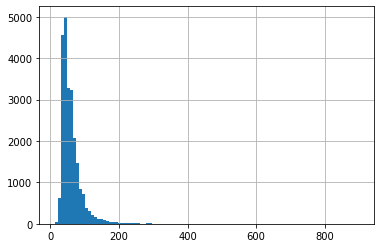

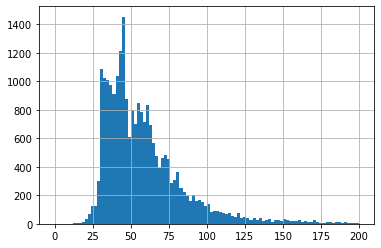

In [ ]:
data['total_area'].hist(bins=100)
plt.show()
data['total_area'].hist(bins=100, range=(0, 200))
plt.show()

Эти данные мы уже рассматривали подробно когда выясняли есть ли в них аномалии. Мы можем видеть что большинство квартир имеют плозадь между 25 и 75 квадратных метров, меьше практически нет, но имеются также квартиры площадью более 100 кв.м, но их относительно мало.

##### Гистограмма для жилой площади

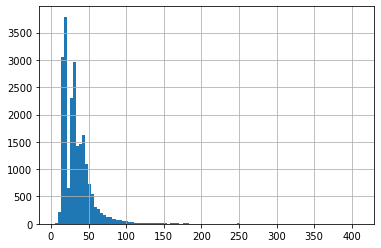

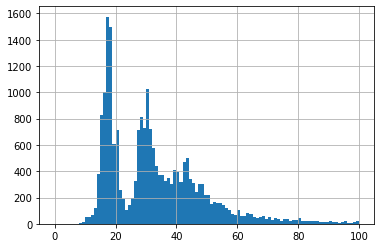

In [ ]:
data['living_area'].hist(bins=100)
plt.show()
data['living_area'].hist(bins=100, range=(0, 100))
plt.show()

Мы видим 2 пика: квартиры с жилой площадью около 19 кв. метров и 30 кв. метров, количество проданных квартир с большей площадью плавно идёт на спад. Квартир площадью больше 80 метров уже относительно общего числа очень мало.

##### Гистограмма для цены объекта

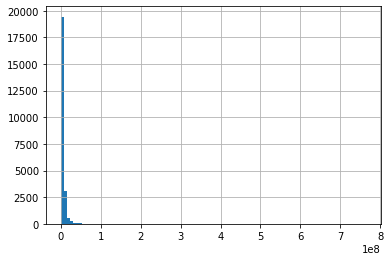

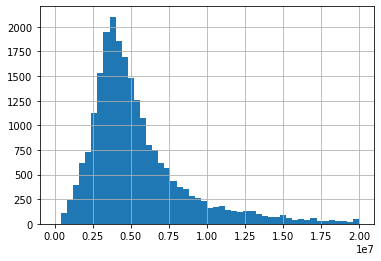

In [ ]:
data['last_price'].hist(bins=100)
plt.show()
data['last_price'].hist(bins=50, range=(0, 20000000))
plt.show()

На общей гистограмме плохо видно основную массу квартир из-за 9 дорогих квартир в Санкт-Перебурге, они были не ошибочными поэтому мы оставили их в данных. На срезе основой массы квартир мы можем увидеть правильное распределение: сначала количество проданных по определённой цене квартир повышается, а потом понижается, пик находится в районе 4 миллионов рублей.

##### Гистограмма для высоты потолков

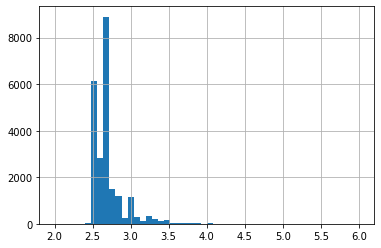

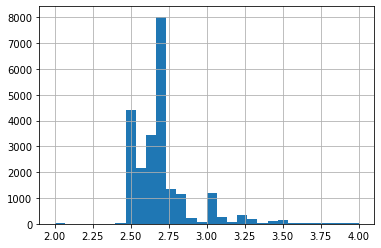

In [ ]:
data['ceiling_height'].hist(bins=50)
plt.show()
data['ceiling_height'].hist(bins=30, range=(2, 4))
plt.show()

Видим 3 пика: самая популярная высота потолков в продаваемых квартирах это ~2.5, ~2.6 и 3 метров, более высокие потолки встеречаются реже т.к. в основном это элитное жильё и/или частный сектор, такой недвижимости меньше.

##### Гистограмма для этажей квартир

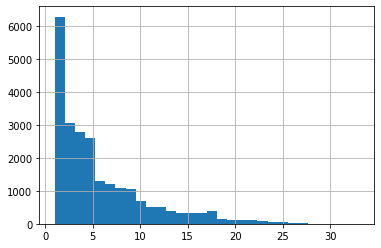

In [ ]:
data['floor'].hist(bins=30)
plt.show()

Больше всего продаётся квартир на этажах пониже, от 1-го до 6-го, количество квартир выше плавно сходит на нет.

##### Гистограмма для типов этажей квартир

<AxesSubplot:>

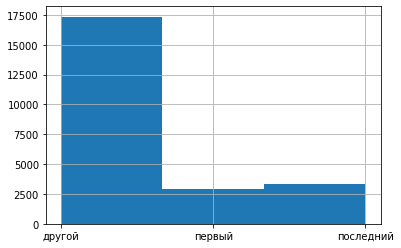

In [ ]:
data['floor_type'].hist(bins=3)

Больше всего квартир не с первого и не с последнего этажей, однако можно заметить что квартир последних этажей больше чем с первых.

##### Гистограмма для общего числа этажей в доме

<AxesSubplot:>

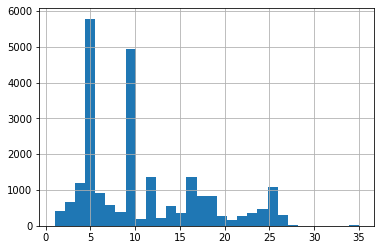

In [ ]:
data['floors_total'].hist(bins=30)

Много 6 этажных домов и 9 этажных, количество домой с другой этажностью примерно одинаково мало

##### Гистограмма для расстояния до центра города в метрах

<AxesSubplot:>

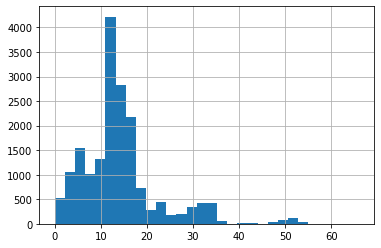

In [ ]:
data['cityCenters_nearest_km'].hist(bins=30)

В основном продаются квартиры в 11 километрах от центра города, ещё один пик это 5 километров от центра

##### Гистограмма для расстояния до аэропорта в метрах

<AxesSubplot:>

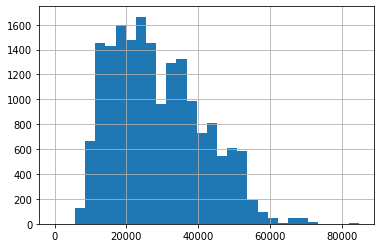

In [ ]:
data['airports_nearest'].hist(bins=30)

В основном дома находятся на расстоянии 20 км от аэропорта, второй пик ~37 километров

##### Гистограмма для  расстония до близжайшего парка

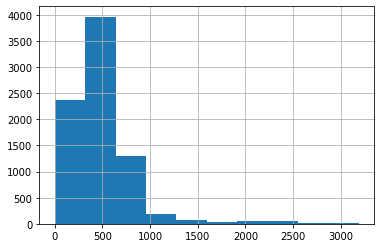

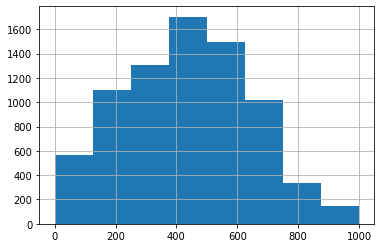

In [ ]:
data['parks_nearest'].hist(bins=10)
plt.show()
data['parks_nearest'].hist(bins=8, range=(0, 1000))
plt.show()

Такой всплекс получился по причине заполнения пропусков медианой по городу. Средняя квартира находится на расстоянии от 200 до 600 метров до парка.

##### Гистограмма для дня и месяца публикации объявления

In [ ]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,day_of_sell,locality_name_processed,sq_m_price,weekday,month,year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.700,16.0,51.0,8,True,...,755.0,NaN,2019-04-21,Санкт-Петербург,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.615,11.0,18.6,1,True,...,NaN,81.0,2019-01-18,поселок Шушары,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.700,5.0,34.3,4,True,...,574.0,558.0,2015-10-04,Санкт-Петербург,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.700,14.0,NaN,9,True,...,234.0,424.0,2015-09-07,Санкт-Петербург,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.030,14.0,32.0,13,True,...,48.0,121.0,2018-08-03,Санкт-Петербург,100000.000000,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.700,5.0,73.3,3,True,...,381.0,NaN,2017-05-05,Санкт-Петербург,72490.845228,1,3,2017,другой,4.0
23695,14,3100000.0,59.00,2018-01-15,3,2.500,5.0,38.0,4,True,...,NaN,45.0,2018-03-01,Тосно,52542.372881,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,True,...,NaN,NaN,2018-03-28,село Рождествено,44091.710758,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.000,17.0,NaN,12,True,...,196.0,602.0,2017-05-12,Санкт-Петербург,149511.400651,1,3,2017,другой,10.0


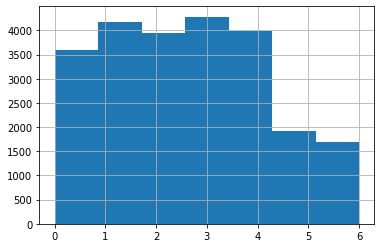

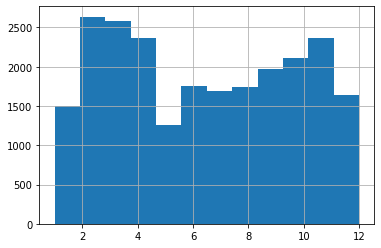

In [ ]:
data['weekday'].hist(bins=7)
plt.show()
data['month'].hist(bins=12)
plt.show()

Меньше всего выставлено объявлений в выходные дни и в месяца май, декабрь и январь, а больше всего в февраль, март и апрель. Скорее всего дело в том, что люди видят процесс продажи квартиры делом ответственным и сложным, и откладывают его с выходных и праздников на потом.

#### Исследование, как быстро продавали квартиры

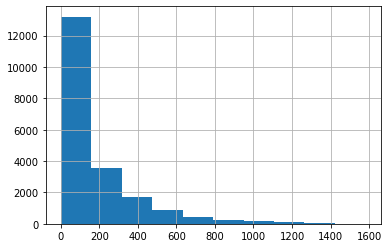

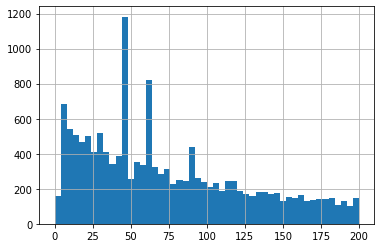

In [ ]:
data['days_exposition'].hist()
plt.show()
data['days_exposition'].hist(range=(0, 200), bins=50)
plt.show()

In [ ]:
'Медиана', data['days_exposition'].median(), 'Средняя', data['days_exposition'].mean()

('Медиана', 95.0, 'Средняя', 180.91035934593165)

In [ ]:
data['days_exposition'].describe()

count    20426.000000
mean       180.910359
std        219.724236
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

##### Подвывод как долго продавались квартиры
Средняя продажа квартиры занимает 103, но есть сильно выбивающиеся значения (например квартира продавалась более 1500 дней), которые искажают среднюю. Слишком долгими продажами можно назвать те, которые выходят за пределы 3 перцентиля (продавали более 248 дней), а слишком быстрыми те, которые не пересекли 1 перцентиль (продавались меньше 45 дней).

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

In [ ]:
#Таблица корреляций
factors=data[['last_price', 'total_area', 'living_area', 'kitchen_area']]
factors.corr()

,last_price,total_area,living_area,kitchen_area
last_price,1.000000,0.653685,0.567251,0.520484
total_area,0.653685,1.000000,0.940173,0.609549
living_area,0.567251,0.940173,1.000000,0.429213
kitchen_area,0.520484,0.609549,0.429213,1.000000


Больше всего взаимосвязи между ценой и
 - общей площадью (корреляция 71%)
 - жилой площадью (корреляция 62%)
 - площадью кухни (корреляция 54%)

Месяц, день недели, год и кол-во комнат это категориальные данные о корреляции между ценой ними ни о чем не говорят, мы посмотрим на графики

##### total_area

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

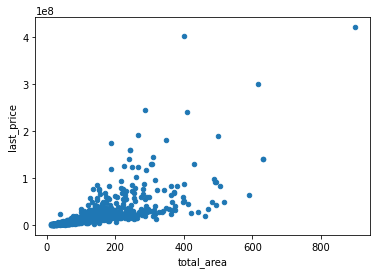

In [ ]:
data.pivot_table(index='total_area',
                 values='last_price',
                 aggfunc='median').reset_index().plot(kind='scatter',
                                                      x='total_area',
                                                      y='last_price')

In [ ]:
data['last_price'].corr(data['total_area'])

0.6536847372334588

Чем больше общая площадь, тем больше цена квартиры

##### living_area

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

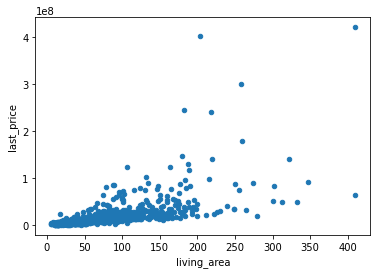

In [ ]:
data.pivot_table(index='living_area',
                 values='last_price',
                 aggfunc='median').reset_index().plot(kind='scatter',
                                                      x='living_area',
                                                      y='last_price')

In [ ]:
data['last_price'].corr(data['living_area'])

0.5672512073681092

Чем больше жилая площадь, тем больше цена квартиры

##### kitchen_area

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

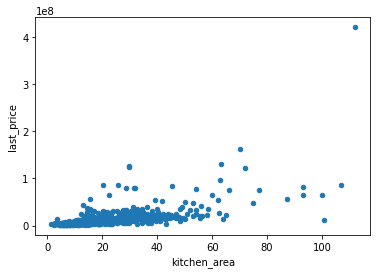

In [ ]:
data.pivot_table(index='kitchen_area',
                 values='last_price',
                 aggfunc='median').reset_index().plot(kind='scatter',
                                                      x='kitchen_area',
                                                      y='last_price')

In [ ]:
data['last_price'].corr(data['kitchen_area'])

0.520484377298759

Чем больше площадь кухни, тем больше цена квартиры

##### rooms

<AxesSubplot:title={'center':'цена по кол-ву комнат'}, xlabel='rooms'>

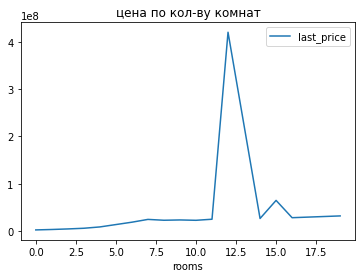

In [ ]:
data.pivot_table(index='rooms',
                 values='last_price',
                 aggfunc='median').reset_index().plot(x='rooms',
                                                      y='last_price',
                                                      title='цена по кол-ву комнат')

Медианная цена на квартиру резко возрастает в недвижимости с 12 комнатами. Это связано с тем, что такие дома редки и поэтому запрошенная цена единственного 11-комнатного дома может задать такую высокую планку. В целом можно увидеть что количество комнат связано с ростом цены, чем больше комнат тем больше цены.

##### weekday

<AxesSubplot:title={'center':'цена по дням недели'}, xlabel='weekday'>

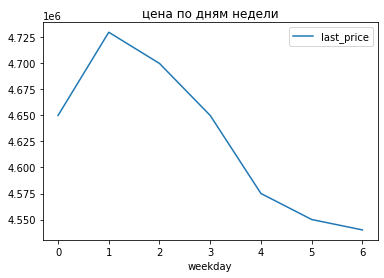

In [ ]:
data.pivot_table(index='weekday',
                 values='last_price',
                 aggfunc='median').reset_index().plot(x='weekday',
                                                      y='last_price',
                                                      title='цена по дням недели')

по оси Y мы можем заметить что различие цены незначительное, день недели никак не влияет на цены квартиры. Тем не менее стоит заметить, что в выходные цены немного ниже чем в будни, самые "дорогой" день был вторником

##### month

<AxesSubplot:title={'center':'цена по месяцам'}, xlabel='month'>

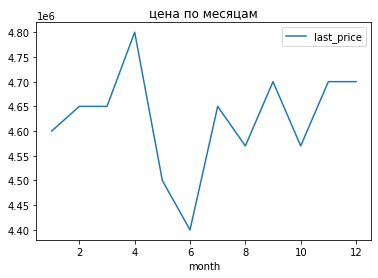

In [ ]:
data.pivot_table(index='month', values='last_price', aggfunc='median').reset_index().plot(x='month', y='last_price', title='цена по месяцам')

Самые дешевые цены были опубликованы в июне, но от самых дорогих, опубликованных  в апреле, они отличаются лишь на 500 000. Связь между месяцем и ценой квартиры есть, но она незначительна

##### year

In [ ]:
data.pivot_table(index='year', columns='month', values='last_price', aggfunc='median')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13280560.0,7300000.0
2015,7425000.0,5570000.0,5607710.0,5215000.0,5100000.0,4875000.0,5400000.0,5550000.0,6210726.5,5029500.0,5170000.0,4880000.0
2016,5050000.0,4625000.0,4550000.0,4550000.0,4325000.0,4515000.0,4400000.0,4070000.0,4800000.0,5000000.0,4445000.0,4625000.0
2017,4580000.0,4750000.0,4500000.0,4650000.0,4500000.0,4225000.0,4500000.0,4500000.0,4650000.0,4300000.0,4500000.0,4400000.0
2018,4300000.0,4350000.0,4250000.0,4500000.0,4650000.0,4400000.0,4715000.0,4600003.0,4650000.0,4700000.0,4800000.0,5100000.0
2019,5000000.0,5200000.0,5000000.0,5043500.0,5250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


По 2014 году есть данные только по последним двум месяцам, такие данные могут быть непоказательными, мы не будем их учитывать.

<AxesSubplot:title={'center':'медианная цена квартиры'}, xlabel='year'>

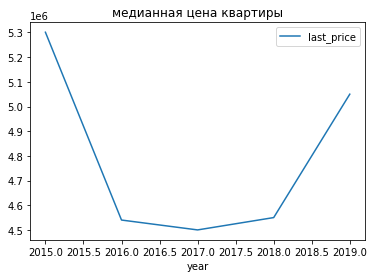

In [ ]:
data_without_2014 = data.query('year > 2014')
data_without_2014.pivot_table(index='year',
                              values='last_price',
                              aggfunc='median').reset_index().plot(x='year',
                                                                   y='last_price',
                                                                   title='медианная цена квартиры')

Самые дорогие квартиры были в 2015 году, потом следует тенденция на снижение вплоть до 2018 года, где цены на недвижимость снова начинают резко расти.

<AxesSubplot:title={'center':'Общая площадь'}, xlabel='year'>

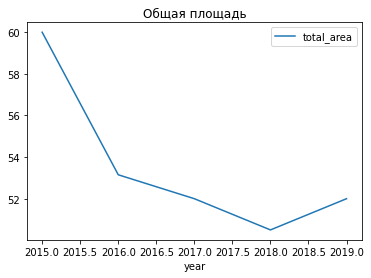

In [ ]:
data_without_2014.pivot_table(index='year', values='total_area', aggfunc='median').reset_index().plot(x='year', y='total_area', title='Общая площадь')

C годами также менялась медианная площадь продаваемых квартир, изменение медианной цены по годам коррелирует с изменением площади квартиры. Это можно было ожидать по найденной корреляции в начале.

<AxesSubplot:title={'center':'количество объявлений о продаже'}, xlabel='year'>

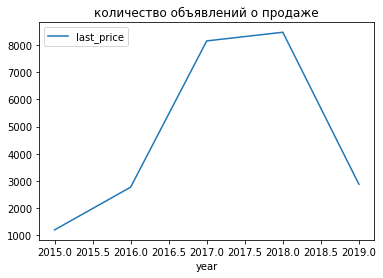

In [ ]:
data_without_2014.pivot_table(index='year',
                              values='last_price',
                              aggfunc='count').reset_index().plot(x='year',
                                                                  y='last_price',
                                                                  title='количество объявлений о продаже')

Количество объявлений повторяет движение медианы цены равно наоборот, чем больше объявлений тем ниже цена.

##### floor_type

<AxesSubplot:title={'center':'цена по типу этажа'}, xlabel='floor_type'>

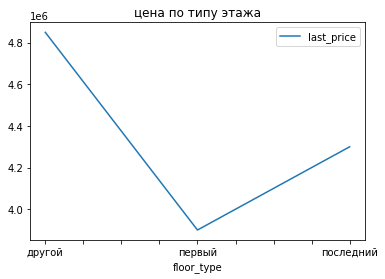

In [ ]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').reset_index().plot(x='floor_type', y='last_price', title='цена по типу этажа')

Первые этажи дешевле остальных категорий. Это объясняется тем что первые этажи относительно других этажей менее комфортны: там холоднее, грязнее, может быть шумно из-за близлежайших коммерческих помещений, квартиры более подвержены влажности. Последние этажи дороже первых но дешевле других, летом там может быть жарко, а в дожди может протекать крыша.

##### Подвывод влияния на общую стоимость квартиры
Самое большое влияние на цену имеют:
 - общая площадь (корреляция 71%)
 - жилая площадь (корреляция 62%)
 - площадь кухни (корреляция 54%)
 - количество комнат (чем больше комнат, тем выше цена)
 - год публикации объявления (до 2019 года цены снижаются)
 - первые и послежние этажи дешевле остальных
 - чем больше предложений продажи, тем ниже медианная цена

#### Населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [ ]:
#Создаём переменную с 10 самыми частовстречаемыми городами
most_freq_cities = data.pivot_table(index='locality_name_processed',
                                    values='last_price',
                                    aggfunc='count').reset_index().sort_values(by='last_price',
                                                                               ascending=False).head(10)
most_freq_cities = most_freq_cities.rename(columns = {'last_price':'count'})
most_freq_cities

,locality_name_processed,count
34,Санкт-Петербург,15642
205,поселок Мурино,552
268,поселок Шушары,439
3,Всеволожск,398
33,Пушкин,369
13,Колпино,338
212,поселок Парголово,327
6,Гатчина,307
80,деревня Кудрово,299
4,Выборг,237


##### Подвывод по стоимости кв. метра
Средняя цена квартиры падала до 2019 года и потом начала резко расти, это связано с общей площадью продаваемых квартир и количеством объявлений о продаже (чем больше объявлений тем меньше цена)

In [ ]:
#Находим по этим городам среднюю цену кв.метра
data.query('locality_name_processed.isin(@most_freq_cities.locality_name_processed)')[['locality_name_processed','sq_m_price']].pivot_table(index='locality_name_processed', values='sq_m_price', aggfunc='mean').sort_values(by='sq_m_price')

,sq_m_price
locality_name_processed,
Выборг,58141.909153
Всеволожск,68654.473986
Гатчина,68746.146763
Колпино,75424.579098
поселок Шушары,78551.344545
поселок Мурино,85629.568678
поселок Парголово,90175.913458
деревня Кудрово,92473.547576
Пушкин,103125.819291


Среди самых частовстречаемых городов при продажи квартиры, самый дорогой квардратный метр в Санкт-Петерубрге, самый дешевый во Всеволожске

#### Средняя цена каждого километра в Спб

In [ ]:
#сводная таблица по цене на каждый километр
spb_only = data.query('locality_name_processed == "Санкт-Петербург"')
spb_only.pivot_table(index='cityCenters_nearest_km', values='last_price').sort_values('cityCenters_nearest_km')

,last_price
cityCenters_nearest_km,
0.0,3.144912e+07
1.0,2.120672e+07
2.0,1.778832e+07
3.0,1.113739e+07
4.0,1.330428e+07
5.0,1.445600e+07
6.0,1.533842e+07
7.0,1.477515e+07
8.0,9.940594e+06


<AxesSubplot:xlabel='cityCenters_nearest_km'>

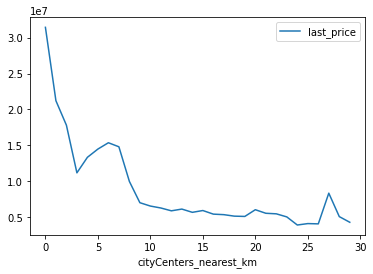

In [ ]:
#Визуализация сводной таблицы
spb_only.pivot_table(index='cityCenters_nearest_km',
                     values='last_price').sort_values('cityCenters_nearest_km').plot()

Мы видим три пика:
 - Очень дорогие квартиры с расстоянием до центра 0 км, это квартиры которые находятся в центре города
 - Второй пик на 6 километре
 - Третий пик на 27 километре

Также интересен провал на 3 и 9-26 километрах.

Чтобы понять причины второго и третьего пунктов, посмотрим на данные по этим километрам.

In [ ]:
spb_only.query('cityCenters_nearest_km == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,day_of_sell,locality_name_processed,sq_m_price,weekday,month,year,floor_type,cityCenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,True,...,NaN,128.0,2018-01-12,Санкт-Петербург,193918.918919,1,11,2017,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.70,2.0,16.5,2,True,...,NaN,178.0,2018-04-13,Санкт-Петербург,70312.500000,1,2,2018,последний,27.0


Причина всплеска на 27 километре это наличие только одной квартиры и её высокая цена

In [ ]:
#Сводная таблица по каждому километру и этажам
spb_only = spb_only.pivot_table(index='cityCenters_nearest_km',
                     columns='floor_type',
                     values='last_price',
                     aggfunc=['mean', 'count'])

#считаем долю этажей для каждого километра
spb_only['ratio_other'] = spb_only['count']['другой']/(spb_only['count']['первый']
                                                       + spb_only['count']['последний']
                                                       + spb_only['count']['другой'])

spb_only['ratio_first'] = spb_only['count']['первый']/(spb_only['count']['другой']
                                                       + spb_only['count']['последний']
                                                       + spb_only['count']['первый'])

spb_only['ratio_last'] = spb_only['count']['последний']/(spb_only['count']['другой']
                                                         + spb_only['count']['первый']
                                                         + spb_only['count']['последний'])

spb_only

mean                               count  \
floor_type                    другой        первый     последний  другой   
cityCenters_nearest_km                                                     
0.0                     3.556015e+07  1.606667e+07  2.243077e+07    20.0   
1.0                     2.168691e+07  1.523871e+07  2.304692e+07   122.0   
2.0                     1.847547e+07  8.961089e+06  2.113140e+07   184.0   
3.0                     1.174687e+07  8.933089e+06  1.102107e+07   214.0   
4.0                     1.305375e+07  7.590329e+06  1.830572e+07   494.0   
5.0                     1.414391e+07  8.867958e+06  1.913129e+07   689.0   
6.0                     1.495534e+07  1.030738e+07  2.045390e+07   455.0   
7.0                     1.528738e+07  9.101429e+06  1.501021e+07   326.0   
8.0                     9.434113e+06  5.773520e+06  1.659867e+07   471.0   
9.0                     7.063569e+06  5.642037e+06  7.302936e+06   450.0   
10.0                    6.795066e+06  5.094865e+06  5.929099e+06   545.0   
11.0                    6.492139e+06  5.065036e+06  5.637770e+06   907.0   
12.0                    5.948063e+06  5.328715e+06  5.487986e+06  1266.0   
13.0                    6.241541e+06  4.800031e+06  5.756962e+06  1191.0   
14.0                    5.657141e+06  5.090910e+06  5.831336e+06  1038.0   
15.0                    5.901213e+06  5.148122e+06  6.395122e+06  1266.0   
16.0                    5.460992e+06  4.990728e+06  5.060348e+06  1010.0   
17.0                    5.265520e+06  5.416368e+06  5.429768e+06   681.0   
18.0                    5.059588e+06  5.335123e+06  5.111844e+06   205.0   
19.0                    5.202155e+06  4.279556e+06  4.795720e+06   121.0   
20.0                    6.137595e+06  4.700000e+06  3.315000e+06    45.0   
21.0                    5.223447e+06  5.012747e+06  7.119057e+06    87.0   
22.0                    5.228244e+06  6.159585e+06  6.467839e+06   168.0   
23.0                    4.970254e+06  4.149000e+06  5.637692e+06    63.0   
24.0                    3.854799e+06  2.400000e+06  5.300000e+06    24.0   
25.0                    4.015174e+06  4.078070e+06  4.680000e+06    20.0   
26.0                    3.994333e+06  3.912353e+06  4.153916e+06    24.0   
27.0                    1.435000e+07           NaN  2.250000e+06     1.0   
28.0                    5.409500e+06  4.201500e+06  5.144000e+06     4.0   
29.0                    4.850000e+06  4.050000e+06  4.370000e+06     1.0   

                                        ratio_other ratio_first ratio_last  
floor_type             первый последний                                     
cityCenters_nearest_km                                                      
0.0                       3.0       4.0    0.740741    0.111111   0.148148  
1.0                      24.0      46.0    0.635417    0.125000   0.239583  
2.0                      45.0      81.0    0.593548    0.145161   0.261290  
3.0                      55.0      79.0    0.614943    0.158046   0.227011  
4.0                      79.0     115.0    0.718023    0.114826   0.167151  
5.0                      82.0     144.0    0.753005    0.089617   0.157377  
6.0                      65.0      98.0    0.736246    0.105178   0.158576  
7.0                      32.0      62.0    0.776190    0.076190   0.147619  
8.0                      53.0      69.0    0.794266    0.089376   0.116358  
9.0                      54.0      86.0    0.762712    0.091525   0.145763  
10.0                     74.0      99.0    0.759053    0.103064   0.137883  
11.0                    147.0     114.0    0.776541    0.125856   0.097603  
12.0                    178.0     153.0    0.792736    0.111459   0.095805  
13.0                    115.0     144.0    0.821379    0.079310   0.099310  
14.0                    111.0     125.0    0.814757    0.087127   0.098116  
15.0                    148.0     147.0    0.811019    0.094811   0.094170  
16.0                    129.0     126.0    0.798419    0.101

##### Подвывод по цене каждого километра
На 3-м километре продавалось больше квартир на первом этаже, отсюда и провал
на 6-м километре цена последнего этажа выше чем всех остальных, и доля квартир с последнего этажа на продаже больше, отсюда и пик
с 9 по 26 километр средняя цена постепенно уменьшается из-за отдаленности от центра, а выброс на 27 километре связан с тем что там продаётся лишь одна квартира по высокой цене

В итоге можем прийти в выводу что по отдаленности от центра цена квартиры снижается, но это может быть неочевидно из-за разной доли квартир на первом, последнем и других этажах.

### Общий вывод

Мы изучили распределение данных, исправили аномалии или удалили данные которые было невозможно исправить, унифицировали названия населенных пунктов, заполнили пропуски, добавили дополнительные столбцы для анализа и провели исследование. В ходе исследования мы пришли к следующим выводам:

 1. Средняя продажа квартиры занимает 103 дня (медиана), но есть сильно выбивающиеся значения (например квартира продавалась более 1500 дней), которые искажают среднюю. Слишком долгими продажами можно назвать те, которые выходят за пределы 3 перцентиля (продавали более 248 дней), а слишком быстрыми те, которые не пересекли 1 перцентиль (продавались меньше 45 дней).


 2. Из данных факторов, самое большое влияние на цену имеют:
 - общая площадь (корреляция 71%)
 - жилая площадь (корреляция 62%)
 - площадь кухни (корреляция 54%)
 - количество комнат (чем больше комнат, тем выше цена)
 - первые и послежние этажи дешевле остальных
 - чем больше предложений продажи, тем ниже медианная цена

  Не имели влияния:
  - день недели, в который была выставлена квартира
  - месяц, в который была выставлена квартира

 3. Средняя цена квартиры падала до 2019 года и потом начала резко расти, это связано с общей площадью продаваемых квартир и количеством объявлений о продаже (чем больше объявлений тем меньше цена)


 4. По отдаленности от центра города цена квартиры снижается, однако из-за разной доли первых, последних и других этажей это может быть неочевидно

